✅ Đang chạy trên thiết bị: cuda

🔄 Đang xử lý dữ liệu...
📊 Dữ liệu sau khi lọc Top 20 bệnh: 63366 dòng
💊 Các bệnh sẽ học: ['Birth Control', 'Depression', 'Pain', 'Anxiety', 'Acne'] ...

🧬 Đang tải BioBERT Tokenizer...

🚀 Đang khởi tạo Model BioBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔥 BẮT ĐẦU HUẤN LUYỆN (Sẽ mất khoảng 15-30 phút tùy dữ liệu)...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.451900,0.430468,0.863184,0.862461,0.865766,0.863184
2,0.229400,0.279999,0.920230,0.919484,0.920572,0.920230


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.451900,0.430468,0.863184,0.862461,0.865766,0.863184
2,0.229400,0.279999,0.920230,0.919484,0.920572,0.920230
3,0.074600,0.229559,0.946899,0.946832,0.947229,0.946899



📊 Đang vẽ biểu đồ báo cáo...


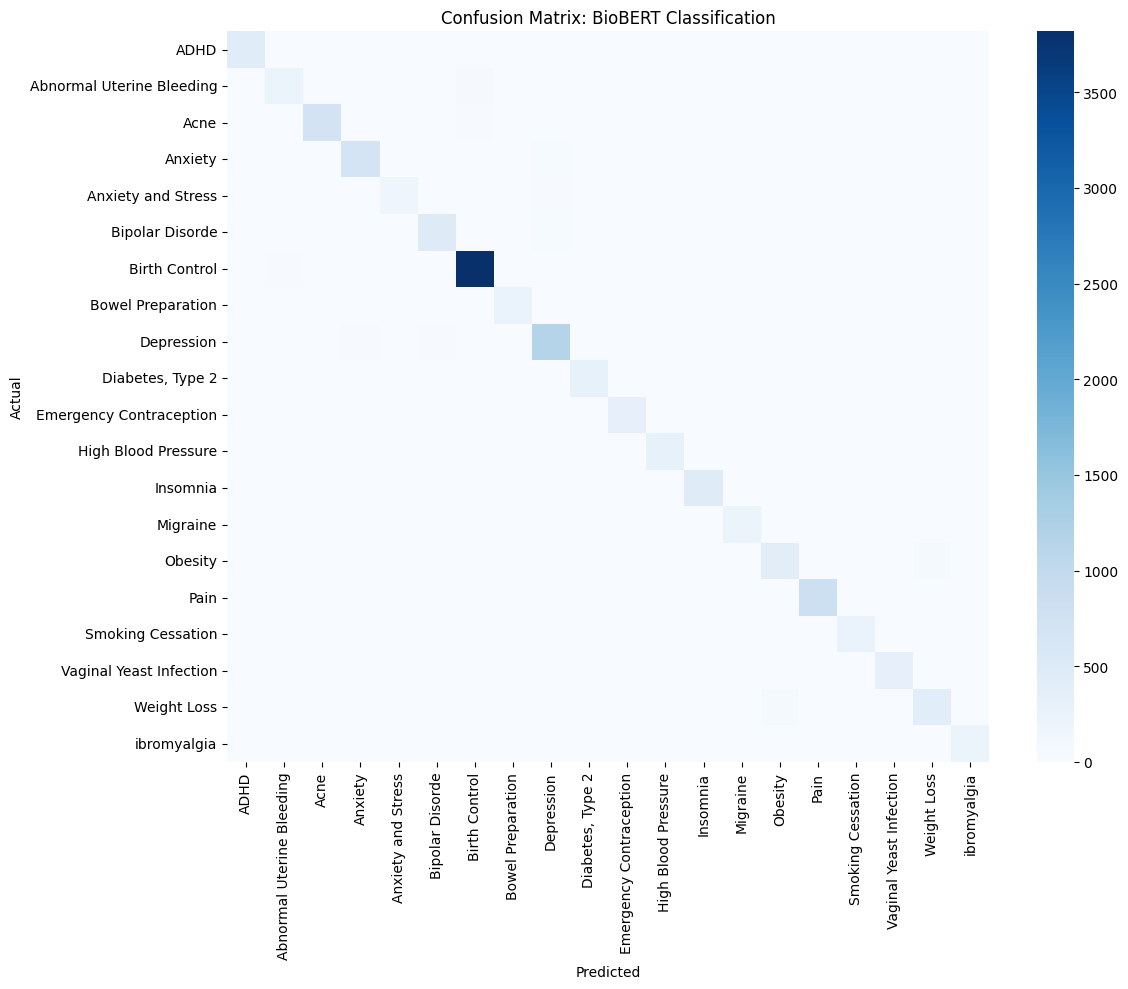

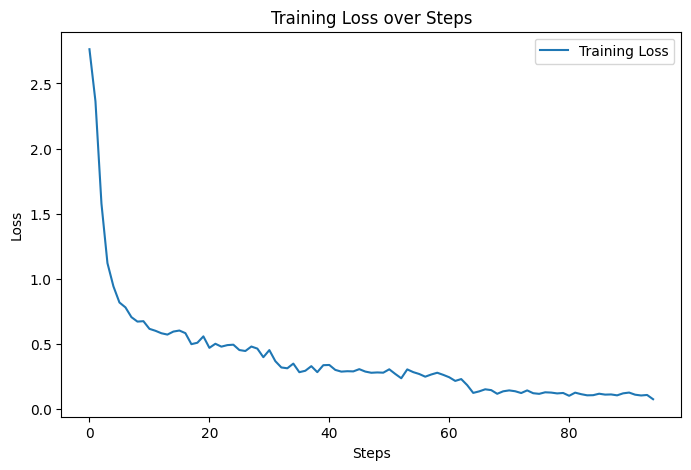


📝 Classification Report:
                           precision    recall  f1-score   support

                     ADHD       0.98      0.96      0.97       450
Abnormal Uterine Bleeding       0.93      0.81      0.87       259
                     Acne       0.98      0.95      0.97       739
                  Anxiety       0.92      0.89      0.91       763
       Anxiety and Stress       0.86      0.84      0.85       229
          Bipolar Disorde       0.94      0.89      0.92       552
            Birth Control       0.98      0.99      0.98      3860
        Bowel Preparation       1.00      0.98      0.99       256
               Depression       0.89      0.94      0.91      1238
         Diabetes, Type 2       0.97      0.97      0.97       323
  Emergency Contraception       0.98      0.97      0.98       331
      High Blood Pressure       0.97      0.96      0.96       313
                 Insomnia       0.97      0.95      0.96       493
                 Migraine       0.9

In [2]:
# ==============================================================================
# PHẦN 1: CÀI ĐẶT MÔI TRƯỜNG & THƯ VIỆN (Chạy cell này đầu tiên)
# ==============================================================================
!pip install -q transformers torch pandas scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import torch
import re
import html
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Kiểm tra GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Đang chạy trên thiết bị: {device}")
if device.type != 'cuda':
    print("⚠️ CẢNH BÁO: Bạn chưa bật GPU. Hãy vào Runtime > Change runtime type > T4 GPU để train nhanh hơn gấp 50 lần!")

# ==============================================================================
# PHẦN 2: TẢI & LÀM SẠCH DỮ LIỆU
# ==============================================================================
print("\n🔄 Đang xử lý dữ liệu...")

# 1. Load dữ liệu (Đảm bảo bạn đã upload 2 file này lên Colab)
try:
    df_train = pd.read_csv('/content/drugsComTest_raw.csv')
    df_test = pd.read_csv('/content/drugsComTest_raw.csv')
    df = pd.concat([df_train, df_test])
except FileNotFoundError:
    print("❌ LỖI: Không tìm thấy file csv. Hãy upload 'drugsComTrain_raw.csv' và 'drugsComTest_raw.csv' lên Colab!")
    raise

# 2. Hàm làm sạch chuyên sâu (Chuẩn cho NLP y tế)
def clean_review(text):
    if not isinstance(text, str): return ""
    text = html.unescape(text) # Gỡ lỗi mã hóa HTML
    text = re.sub(r'<[^>]+>', '', text) # Xóa thẻ HTML
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text) # Chỉ giữ lại chữ và dấu câu cơ bản
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['review_clean'] = df['review'].apply(clean_review)
df = df.dropna(subset=['review_clean', 'condition'])

# 3. LỌC DỮ LIỆU (QUAN TRỌNG)
# Lấy Top 20 bệnh phổ biến nhất để Model tập trung học thật giỏi (Demo cho đẹp)
# Nếu muốn train hết, hãy tăng số 20 lên hoặc bỏ dòng này.
TOP_N = 20
top_conditions = df['condition'].value_counts().head(TOP_N).index
df_final = df[df['condition'].isin(top_conditions)].copy()

print(f"📊 Dữ liệu sau khi lọc Top {TOP_N} bệnh: {len(df_final)} dòng")
print(f"💊 Các bệnh sẽ học: {list(top_conditions[:5])} ...")

# 4. Mã hóa nhãn (Label Encoding)
le = LabelEncoder()
df_final['label'] = le.fit_transform(df_final['condition'])

# Chia tập Train/Test (80% - 20%)
# Stratify giúp đảm bảo tỉ lệ bệnh ở tập train và test là như nhau
X_train, X_test, y_train, y_test = train_test_split(
    df_final['review_clean'].tolist(),
    df_final['label'].tolist(),
    test_size=0.2,
    stratify=df_final['label'],
    random_state=42
)

# ==============================================================================
# PHẦN 3: CHUẨN BỊ DATASET CHO BIOBERT
# ==============================================================================
print("\n🧬 Đang tải BioBERT Tokenizer...")
model_name = "dmis-lab/biobert-v1.1"
tokenizer = BertTokenizer.from_pretrained(model_name)

class DrugDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

# Tokenize (Mã hóa văn bản)
# max_length=128 là đủ cho review, giúp train nhanh. Có thể tăng lên 256 nếu review dài.
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128)

train_dataset = DrugDataset(train_encodings, y_train)
test_dataset = DrugDataset(test_encodings, y_test)

# ==============================================================================
# PHẦN 4: CẤU HÌNH & HUẤN LUYỆN (TRAINING)
# ==============================================================================
print("\n🚀 Đang khởi tạo Model BioBERT...")
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))
model.to(device)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,              # 3 vòng là chuẩn bài
    per_device_train_batch_size=16,  # 16 phù hợp với GPU T4 miễn phí
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none" # Tắt wandb để không bị hỏi login
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

print("\n🔥 BẮT ĐẦU HUẤN LUYỆN (Sẽ mất khoảng 15-30 phút tùy dữ liệu)...")
trainer.train()

# ==============================================================================
# PHẦN 5: ĐÁNH GIÁ & VẼ BIỂU ĐỒ (VISUALIZATION)
# ==============================================================================
print("\n📊 Đang vẽ biểu đồ báo cáo...")

# Dự đoán lại trên tập test
preds_output = trainer.predict(test_dataset)
y_preds = preds_output.predictions.argmax(-1)

# 1. Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_preds)
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix: BioBERT Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# 2. Learning Curve (Biểu đồ Loss)
history = trainer.state.log_history
loss_values = [x['loss'] for x in history if 'loss' in x]
plt.figure(figsize=(8, 5))
plt.plot(loss_values, label='Training Loss')
plt.title('Training Loss over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_loss.png')
plt.show()

# 3. Báo cáo chi tiết
print("\n📝 Classification Report:")
print(classification_report(y_test, y_preds, target_names=le.classes_))

# ==============================================================================
# PHẦN 6: LƯU MODEL ĐỂ DÙNG SAU (Quan trọng)
# ==============================================================================
model_path = "./biobert_drug_recommendation_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"\n✅ Đã lưu model vào thư mục: {model_path}")

# ==============================================================================
# PHẦN 7: DEMO ỨNG DỤNG CUỐI CÙNG (AI DOCTOR)
# ==============================================================================
def get_best_drugs(condition_name):
    # Logic Ranking: Score = Rating * log(1 + ReviewCount)
    drugs = df[df['condition'] == condition_name]
    stats = drugs.groupby('drugName').agg({'rating': 'mean', 'usefulCount': 'count'}).reset_index()
    stats = stats[stats['usefulCount'] >= 5] # Lọc thuốc rác
    stats['score'] = stats['rating'] * np.log1p(stats['usefulCount'])
    return stats.sort_values('score', ascending=False).head(5)

def AI_Doctor(symptom_text, age, gender):
    print("\n" + "="*50)
    print(f"🩺 AI DOCTOR (BioBERT) - Bệnh nhân: {gender}, {age} tuổi")
    print(f"📝 Triệu chứng: {symptom_text}")
    print("-" * 50)

    # 1. Dự đoán bệnh (AI)
    inputs = tokenizer(symptom_text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    pred_idx = logits.argmax().item()
    confidence = torch.softmax(logits, dim=1).max().item()
    predicted_disease = le.inverse_transform([pred_idx])[0]

    print(f"🤖 CHẨN ĐOÁN: {predicted_disease.upper()} (Độ tin cậy: {confidence*100:.1f}%)")

    # 2. Kiểm tra an toàn (Rule-based)
    warnings = []
    if age > 60: warnings.append("⚠️ Người cao tuổi: Cẩn thận liều lượng.")
    if age < 12: warnings.append("⚠️ Trẻ em: Cần chỉ định bác sĩ nhi.")
    if gender == 'Female' and 18 <= age <= 40: warnings.append("⚠️ Phụ nữ: Lưu ý thai kỳ/cho con bú.")

    if warnings:
        print("\n🛡️ CẢNH BÁO AN TOÀN:")
        for w in warnings: print(w)

    # 3. Gợi ý thuốc (Ranking)
    print(f"\n💊 THUỐC GỢI Ý (Top 5):")
    top_drugs = get_best_drugs(predicted_disease)
    if not top_drugs.empty:
        for i, row in top_drugs.iterrows():
            print(f"   {i+1}. {row['drugName']} (Score: {row['score']:.1f} | Rating: {row['rating']:.1f})")
    else:
        print("   (Chưa có dữ liệu thuốc phù hợp)")
    print("="*50)

# TEST THỬ
AI_Doctor("I feel extremely sad, hopeless and cannot sleep.", 25, "Female")
AI_Doctor("My lower back hurts and I have difficulty moving.", 65, "Male")

In [1]:
# ==============================================================================
# PHẦN 1: CÀI ĐẶT & CHUẨN BỊ
# ==============================================================================
!pip install -q transformers torch pandas scikit-learn

import pandas as pd
import numpy as np
import torch
import re
import html
import joblib # Dùng để lưu LabelEncoder
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Kiểm tra GPU (Bắt buộc phải có T4 GPU trở lên)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Đang chạy trên thiết bị: {device}")
if device.type != 'cuda':
    print("⚠️ CẢNH BÁO: Bạn chưa bật GPU! Hãy vào Runtime > Change runtime type > T4 GPU ngay!")

# Tạo thư mục để lưu mọi thứ
os.makedirs("./final_model", exist_ok=True)

# ==============================================================================
# PHẦN 2: LOAD & XỬ LÝ DỮ LIỆU FULL
# ==============================================================================
print("\n🔄 Đang xử lý toàn bộ dữ liệu...")

# 1. Load Data
try:
    df_train = pd.read_csv('/content/drugsComTrain_raw.csv')
    df_test = pd.read_csv('/content/drugsComTest_raw.csv')
    df = pd.concat([df_train, df_test])
except:
    print("❌ LỖI: Chưa có file csv. Vui lòng upload lên Colab trước!")
    raise

# 2. Làm sạch văn bản (Cleaning)
def clean_review(text):
    if not isinstance(text, str): return ""
    text = html.unescape(text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['review_clean'] = df['review'].apply(clean_review)
df = df.dropna(subset=['review_clean', 'condition'])

# 3. Lọc bỏ các bệnh quá hiếm (Để model không bị nhiễu)
# Chỉ giữ lại các bệnh có ít nhất 50 review
condition_counts = df['condition'].value_counts()
valid_conditions = condition_counts[condition_counts >= 50].index
df_final = df[df['condition'].isin(valid_conditions)].copy()

print(f"✅ Tổng số mẫu dữ liệu sạch: {len(df_final)}")
print(f"✅ Tổng số loại bệnh (Classes): {len(valid_conditions)}")

# 4. Mã hóa nhãn & Lưu lại (Quan trọng để sau này dùng)
le = LabelEncoder()
df_final['label'] = le.fit_transform(df_final['condition'])

# Lưu LabelEncoder ra file để sau này load lại
joblib.dump(le, './final_model/label_encoder.pkl')
print("💾 Đã lưu LabelEncoder vào ./final_model/label_encoder.pkl")

# Chia tập Train/Test (90% Train - 10% Test vì dữ liệu lớn)
X_train, X_test, y_train, y_test = train_test_split(
    df_final['review_clean'].tolist(),
    df_final['label'].tolist(),
    test_size=0.1,
    stratify=df_final['label'],
    random_state=42
)

# ==============================================================================
# PHẦN 3: TOKENIZE & DATASET
# ==============================================================================
print("\n🧬 Đang chuẩn bị Dataset cho BioBERT...")
model_name = "dmis-lab/biobert-v1.1"
tokenizer = BertTokenizer.from_pretrained(model_name)

class DrugDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

# Tokenize (Max length 128 là đủ cân bằng giữa tốc độ và độ chính xác)
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128)

train_dataset = DrugDataset(train_encodings, y_train)
test_dataset = DrugDataset(test_encodings, y_test)

# ==============================================================================
# PHẦN 4: HUẤN LUYỆN (FULL POWER)
# ==============================================================================
print("\n🚀 Đang khởi tạo Model BioBERT Full Version...")
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))
model.to(device)

# Cấu hình Training tối ưu cho Colab T4
training_args = TrainingArguments(
    output_dir='./results_full',
    num_train_epochs=3,              # 3 Epochs là đủ cho BERT hội tụ
    per_device_train_batch_size=16,  # Batch 16 để không tràn VRAM
    per_device_eval_batch_size=32,
    warmup_steps=1000,               # Warmup nhiều hơn vì data lớn
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=500,
    eval_strategy="epoch",           # Đánh giá sau mỗi epoch
    save_strategy="epoch",           # Lưu model sau mỗi epoch (đề phòng crash)
    load_best_model_at_end=True,     # Lấy model tốt nhất
    fp16=True,                       # Bật Mixed Precision (Train nhanh gấp đôi)
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

print("\n🔥 BẮT ĐẦU HUẤN LUYỆN TOÀN BỘ DỮ LIỆU (Mất khoảng 1-2 tiếng)...")
trainer.train()

# ==============================================================================
# PHẦN 5: LƯU TRỮ SẢN PHẨM CUỐI CÙNG
# ==============================================================================
print("\n💾 Đang lưu model cuối cùng...")
final_path = "./final_model/biobert_full"
model.save_pretrained(final_path)
tokenizer.save_pretrained(final_path)

print(f"🎉 HOÀN TẤT! Model đã được lưu tại: {final_path}")
print("👉 Bạn có thể nén thư mục 'final_model' lại và tải về máy tính để dùng dần.")

# Code nén file để tải về
!zip -r final_biobert_model.zip ./final_model
print("📦 Đã nén xong: final_biobert_model.zip (Hãy tải file này về!)")

🚀 Đang chạy trên thiết bị: cuda

🔄 Đang xử lý toàn bộ dữ liệu...
✅ Tổng số mẫu dữ liệu sạch: 207241
✅ Tổng số loại bệnh (Classes): 254
💾 Đã lưu LabelEncoder vào ./final_model/label_encoder.pkl

🧬 Đang chuẩn bị Dataset cho BioBERT...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]


🚀 Đang khởi tạo Model BioBERT Full Version...


pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔥 BẮT ĐẦU HUẤN LUYỆN TOÀN BỘ DỮ LIỆU (Mất khoảng 1-2 tiếng)...


model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss
1,1.144000,1.069935
2,0.800500,0.841938
3,0.524300,0.739988



💾 Đang lưu model cuối cùng...
🎉 HOÀN TẤT! Model đã được lưu tại: ./final_model/biobert_full
👉 Bạn có thể nén thư mục 'final_model' lại và tải về máy tính để dùng dần.
  adding: final_model/ (stored 0%)
  adding: final_model/biobert_full/ (stored 0%)
  adding: final_model/biobert_full/tokenizer_config.json (deflated 75%)
  adding: final_model/biobert_full/model.safetensors (deflated 7%)
  adding: final_model/biobert_full/config.json (deflated 77%)
  adding: final_model/biobert_full/special_tokens_map.json (deflated 42%)
  adding: final_model/biobert_full/vocab.txt (deflated 49%)
  adding: final_model/label_encoder.pkl (deflated 52%)
📦 Đã nén xong: final_biobert_model.zip (Hãy tải file này về!)


🚀 Đang chạy trên thiết bị: cuda

🔄 Đang chuẩn bị dữ liệu kiểm thử...
✅ Số lượng mẫu kiểm thử hợp lệ: 51843

🧬 Đang load Model từ đĩa cứng (./final_model/biobert_full)...
⏳ Đang Tokenize dữ liệu test...
🚀 Đang chạy đánh giá (Prediction)...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wibucoquyencongdan1234 (wibucoquyencongdan1234-tr-ng-h-kinh-t-tp-h-ch-minh-ueh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



📊 ĐANG VẼ BIỂU ĐỒ...

🏆 ĐỘ CHÍNH XÁC (ACCURACY): 89.61%

📝 Classification Report:
                                                            precision    recall  f1-score   support

                0</span> users found this comment helpful.       0.00      0.00      0.00        24
                1</span> users found this comment helpful.       0.00      0.00      0.00        31
                2</span> users found this comment helpful.       0.00      0.00      0.00        20
                3</span> users found this comment helpful.       0.00      0.00      0.00        17
                4</span> users found this comment helpful.       0.00      0.00      0.00        21
                5</span> users found this comment helpful.       0.00      0.00      0.00        19
                6</span> users found this comment helpful.       0.00      0.00      0.00        18
                7</span> users found this comment helpful.       0.00      0.00      0.00        13
                

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


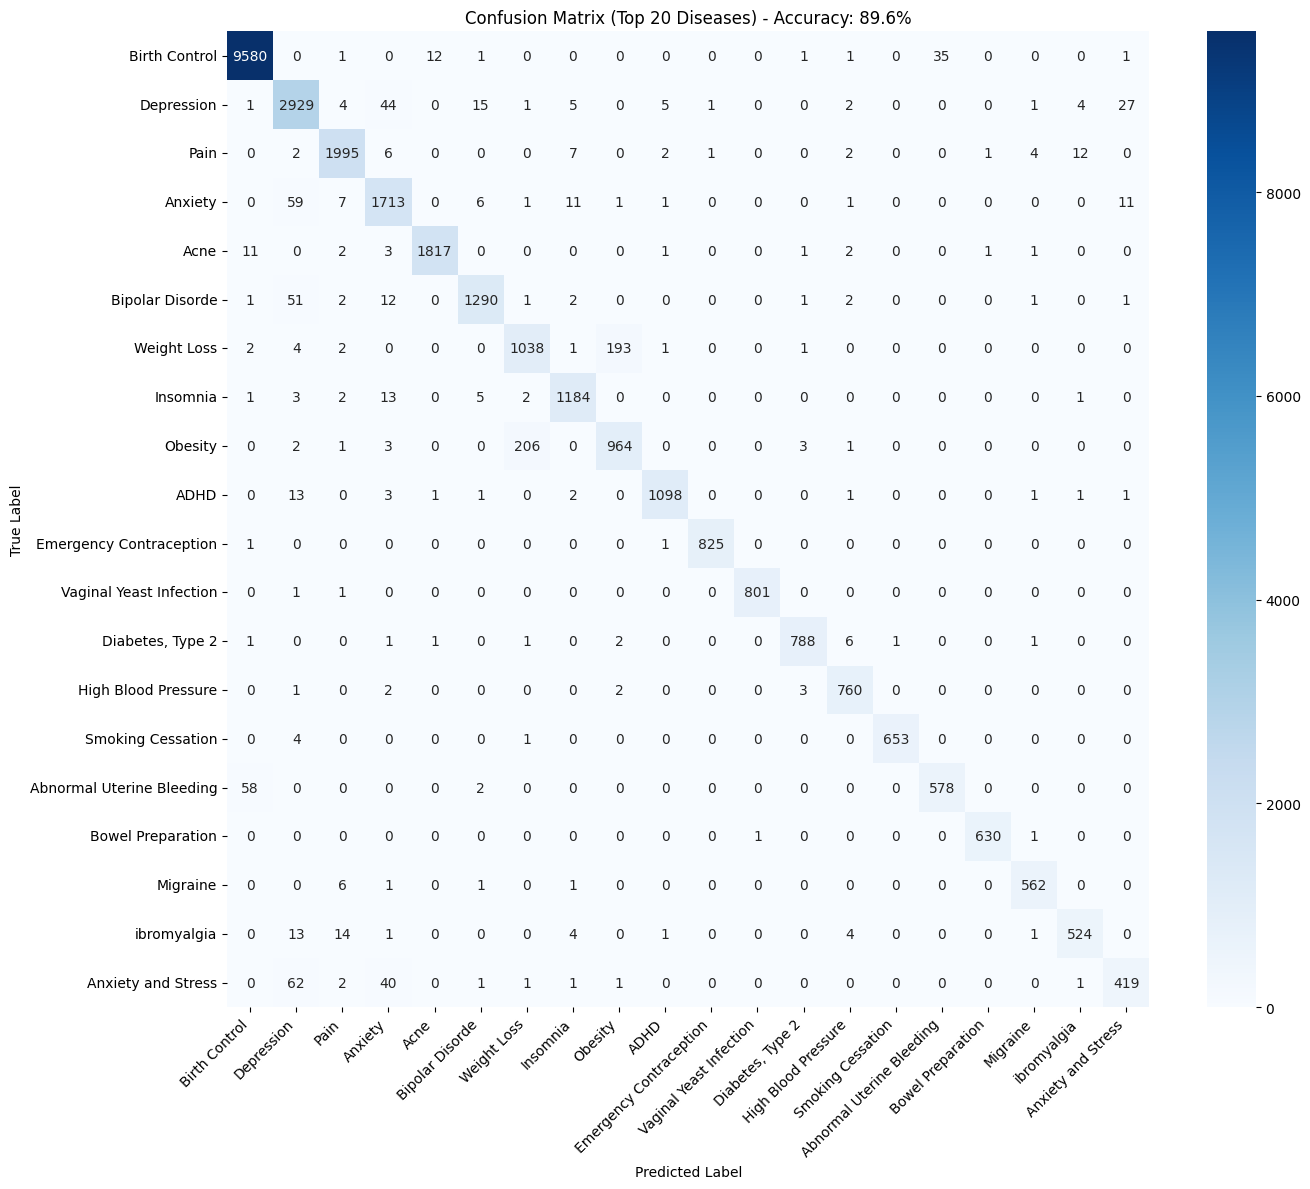

✅ Đã lưu ảnh 'confusion_matrix_restored.png'. Tải về nộp bài nhé!


In [2]:
# ==============================================================================
# PHẦN CỨU NGUY: LOAD MODEL & VẼ BIỂU ĐỒ (CHẠY NGAY)
# ==============================================================================
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Kiểm tra GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Đang chạy trên thiết bị: {device}")

# 1. LOAD LẠI DỮ LIỆU TEST (Để đánh giá)
print("\n🔄 Đang chuẩn bị dữ liệu kiểm thử...")
# (Phải làm sạch lại giống y hệt lúc train)
try:
    df_test_raw = pd.read_csv('/content/drugsComTest_raw.csv') # Load file test gốc
except:
    print("❌ LỖI: Upload file 'drugsComTest_raw.csv' lên Colab đi bạn!")
    raise

# Load Label Encoder đã lưu
le = joblib.load('./final_model/label_encoder.pkl')

# Hàm làm sạch (Copy lại y chang)
import re
import html
def clean_review(text):
    if not isinstance(text, str): return ""
    text = html.unescape(text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_test_raw['review_clean'] = df_test_raw['review'].apply(clean_review)

# Chỉ lấy các bệnh mà model đã học (Có trong LabelEncoder)
valid_classes = set(le.classes_)
df_test_final = df_test_raw[df_test_raw['condition'].isin(valid_classes)].copy()
df_test_final['label'] = le.transform(df_test_final['condition'])

print(f"✅ Số lượng mẫu kiểm thử hợp lệ: {len(df_test_final)}")

# 2. LOAD MODEL ĐÃ TRAIN XONG
print("\n🧬 Đang load Model từ đĩa cứng (./final_model/biobert_full)...")
model_path = "./final_model/biobert_full"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.to(device)

# 3. CHẠY DỰ ĐOÁN (PREDICT)
# Tạo Dataset
class EvalDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

print("⏳ Đang Tokenize dữ liệu test...")
test_encodings = tokenizer(df_test_final['review_clean'].tolist(), truncation=True, padding=True, max_length=128)
eval_dataset = EvalDataset(test_encodings, df_test_final['label'].tolist())

# Dùng Trainer để predict cho nhanh
trainer = Trainer(model=model)
print("🚀 Đang chạy đánh giá (Prediction)...")
preds_output = trainer.predict(eval_dataset)
y_preds = preds_output.predictions.argmax(-1)
y_true = df_test_final['label'].tolist()

# 4. VẼ BIỂU ĐỒ & XUẤT BÁO CÁO
print("\n📊 ĐANG VẼ BIỂU ĐỒ...")

# A. Accuracy Score
acc = accuracy_score(y_true, y_preds)
print(f"\n🏆 ĐỘ CHÍNH XÁC (ACCURACY): {acc*100:.2f}%")

# B. Classification Report (Chi tiết từng bệnh)
report = classification_report(y_true, y_preds, target_names=le.classes_)
print("\n📝 Classification Report:")
print(report)

# C. Confusion Matrix (Vẽ đẹp để nộp bài)
# Vì số lớp bệnh quá nhiều (>100 bệnh), vẽ hết sẽ bị rối.
# Ta chỉ vẽ Top 20 bệnh phổ biến nhất trong tập test để biểu đồ đẹp.
top_20_indices = pd.Series(y_true).value_counts().head(20).index
mask = np.isin(y_true, top_20_indices)
y_true_top20 = np.array(y_true)[mask]
y_pred_top20 = np.array(y_preds)[mask]
class_names_top20 = le.inverse_transform(top_20_indices)

plt.figure(figsize=(14, 12))
cm = confusion_matrix(y_true_top20, y_pred_top20, labels=top_20_indices)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_top20, yticklabels=class_names_top20)
plt.title(f'Confusion Matrix (Top 20 Diseases) - Accuracy: {acc*100:.1f}%')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('confusion_matrix_restored.png', dpi=300)
plt.show()

print("✅ Đã lưu ảnh 'confusion_matrix_restored.png'. Tải về nộp bài nhé!")

In [5]:
# ==============================================================================
# PHẦN DEMO: ỨNG DỤNG BÁC SĨ AI (CHẠY TỪ MODEL ĐÃ LƯU)
# ==============================================================================
import torch
import pandas as pd
import numpy as np
import joblib
import re
import html
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown
from transformers import BertTokenizer, BertForSequenceClassification

# 1. CẤU HÌNH & LOAD DỮ LIỆU CẦN THIẾT
# ==============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Đang khởi động hệ thống trên: {device}")

# Load Database Thuốc (Dùng để tra cứu & xếp hạng)
print("📂 Đang nạp cơ sở dữ liệu thuốc...")
try:
    df_train = pd.read_csv('/content/drugsComTrain_raw.csv')
    df_test = pd.read_csv('/content/drugsComTest_raw.csv')
    df_db = pd.concat([df_train, df_test])
except:
    print("❌ LỖI: Vui lòng upload lại file csv nếu bạn đã tắt Colab!")
    raise

# Load Model & Tokenizer & LabelEncoder đã lưu
model_path = "./final_model/biobert_full"
le_path = "./final_model/label_encoder.pkl"

print("🧠 Đang nạp 'Bộ não' BioBERT (Vui lòng đợi)...")
try:
    tokenizer = BertTokenizer.from_pretrained(model_path)
    model = BertForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    le = joblib.load(le_path) # Load lại bảng mã hóa tên bệnh
    print("✅ Đã nạp Model thành công!")
except Exception as e:
    print(f"❌ LỖI: Không tìm thấy model. Bạn đã chạy code TRAIN ở trên chưa?\nChi tiết: {e}")
    raise

# 2. CÁC HÀM XỬ LÝ LOGIC (BACKEND)
# ==============================================================================
def clean_text(text):
    text = html.unescape(str(text))
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.strip()

def get_drug_ranking(condition_name):
    # Lọc thuốc theo bệnh
    drugs = df_db[df_db['condition'] == condition_name]
    if drugs.empty: return pd.DataFrame()

    # Tính điểm xếp hạng: Score = Rating * log(1 + ReviewCount)
    stats = drugs.groupby('drugName').agg({'rating': 'mean', 'usefulCount': 'count'}).reset_index()
    stats = stats[stats['usefulCount'] >= 10] # Chỉ lấy thuốc uy tín (>10 review)
    stats['score'] = stats['rating'] * np.log1p(stats['usefulCount'])

    return stats.sort_values('score', ascending=False).head(5)

def check_safety(age, gender):
    warnings = []
    if age > 60: warnings.append("⚠️ Cảnh báo người cao tuổi: Cần giảm liều lượng/tránh thuốc gây buồn ngủ.")
    if age < 12: warnings.append("⚠️ Cảnh báo nhi khoa: Cần chỉ định đặc biệt của bác sĩ.")
    if gender == 'Nữ' and 18 <= age <= 45: warnings.append("⚠️ Cảnh báo thai kỳ: Cần kiểm tra trước khi dùng thuốc.")
    return warnings

# 3. GIAO DIỆN NGƯỜI DÙNG (FRONTEND - IPYWIDGETS)
# ==============================================================================
style = {'description_width': 'initial'}

# Header
header = widgets.HTML("<h2>🩺 AI DOCTOR - HỆ THỐNG GỢI Ý THUỐC THÔNG MINH</h2>")

# Input widgets
txt_input = widgets.Textarea(
    placeholder='Nhập triệu chứng bệnh bằng tiếng Anh (VD: I have severe headache...)',
    description='<b>Triệu chứng:</b>',
    layout=widgets.Layout(width='95%', height='80px'), style=style
)

slider_age = widgets.IntSlider(value=30, min=1, max=100, description='<b>Tuổi:</b>', style=style)
dd_gender = widgets.Dropdown(options=['Nam', 'Nữ'], value='Nam', description='<b>Giới tính:</b>', style=style)

btn_run = widgets.Button(
    description='CHẨN ĐOÁN & KÊ ĐƠN',
    button_style='primary', # Màu xanh dương
    layout=widgets.Layout(width='100%', height='50px'),
    icon='user-md'
)

out = widgets.Output()

def on_click_run(b):
    with out:
        clear_output()
        symptom = txt_input.value
        if len(symptom) < 5:
            print("⚠️ Vui lòng nhập mô tả triệu chứng cụ thể hơn!")
            return

        print("🔄 AI đang phân tích ngữ nghĩa...")

        # B1: Dự đoán bệnh (Model Inference)
        clean_symptom = clean_text(symptom)
        inputs = tokenizer(clean_symptom, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)

        with torch.no_grad():
            logits = model(**inputs).logits

        pred_idx = logits.argmax().item()
        confidence = torch.softmax(logits, dim=1).max().item()

        # Giải mã từ số -> tên bệnh
        predicted_disease = le.inverse_transform([pred_idx])[0]

        # B2: Lấy thuốc & Safety
        top_drugs = get_drug_ranking(predicted_disease)
        safety_warnings = check_safety(slider_age.value, dd_gender.value)

        # B3: Hiển thị kết quả (Render UI)
        display(Markdown("---"))
        display(Markdown(f"### 🔍 KẾT QUẢ CHẨN ĐOÁN"))
        display(Markdown(f"**Bệnh lý dự đoán:** <span style='color:red; font-size:16px'><b>{predicted_disease.upper()}</b></span>"))
        display(Markdown(f"**Độ tin cậy BioBERT:** `{confidence*100:.2f}%`"))

        if safety_warnings:
            display(Markdown(f"#### 🛡️ KIỂM TRA AN TOÀN:"))
            for w in safety_warnings: display(Markdown(f"- {w}"))

        display(Markdown(f"#### Top 5 Thuốc Gợi Ý):"))

        if not top_drugs.empty:
            # Tạo bảng đẹp
            df_show = top_drugs[['drugName', 'rating', 'usefulCount', 'score']].copy()
            df_show.columns = ['Tên Thuốc', 'Rating (1-10)', 'Số người dùng', 'Điểm AI Score']
            display(df_show)
        else:
            print("(Không tìm thấy thuốc phù hợp trong dữ liệu huấn luyện)")
        display(Markdown("---"))

btn_run.on_click(on_click_run)

# Hiển thị toàn bộ App
ui = widgets.VBox([header, txt_input, widgets.HBox([slider_age, dd_gender]), btn_run, out])
display(ui)

🚀 Đang khởi động hệ thống trên: cuda
📂 Đang nạp cơ sở dữ liệu thuốc...
🧠 Đang nạp 'Bộ não' BioBERT (Vui lòng đợi)...
✅ Đã nạp Model thành công!
